# Modeling the anisotropic 3D correlation function on linear scales

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pyccl as ccl
# as easy as pip install hankl
import hankl

### Modeling the matter power spectrum

In [2]:
#Set up a fiducial cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.677, A_s=2.1e-9, n_s=0.9675, transfer_function='boltzmann_camb')

In [3]:
# matter linear power at a pivot redshift (smoothed with a tiny Gaussian for stability)
k_Mpc=np.logspace(-4, 2, 2**12)
z_p=3
# smooth power with Gaussian for stability
sig_Mpc=0.2
P_L_Mpc=ccl.power.linear_matter_power(cosmo, k_Mpc, a=1/(1+z_p)) * np.exp(-(k_Mpc*sig_Mpc)**2)

In [4]:
# ratio of the linear growth factor at z and at z_p
def D_z_p(z,z_p):
    # this should be a proper call to a function in CCL / CAMB / CLASS, but for now I'll just assume EdS
    return (1+z_p)/(1+z)

In [5]:
# logarithmic growth rate at a given redshift
def f_z(z):
    # this should be a proper call to a function in CCL / CAMB / CLASS, but for now I'll just assume EdS
    return 1

### Compute the auxiliary functions (eq. 4.9 in Slosar et al. 2011) 

In [6]:
r_Mpc, xi_L_0 = hankl.P2xi(k_Mpc, P_L_Mpc, l=0)
_, xi_L_2 = hankl.P2xi(k_Mpc, P_L_Mpc, l=2)
_, xi_L_4 = hankl.P2xi(k_Mpc, P_L_Mpc, l=4)
# keep only the real part (imag=0) and create 1D interpolation functions
#f = interpolate.interp1d(x, y)
xi_L_0 = scipy.interpolate.interp1d(r_Mpc, xi_L_0.real)
xi_L_2 = scipy.interpolate.interp1d(r_Mpc, xi_L_2.real)
xi_L_4 = scipy.interpolate.interp1d(r_Mpc, xi_L_4.real)

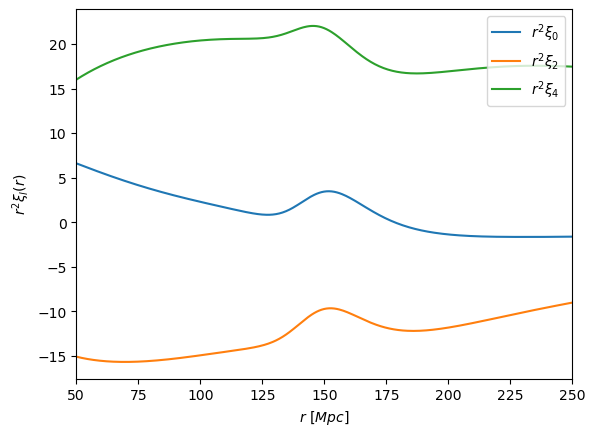

In [7]:
plt.plot(r_Mpc, r_Mpc**2*xi_L_0(r_Mpc), label=r'$r^{2}\xi_{0}$')
plt.plot(r_Mpc, r_Mpc**2*xi_L_2(r_Mpc), label=r'$r^{2}\xi_{2}$')
plt.plot(r_Mpc, r_Mpc**2*xi_L_4(r_Mpc), label=r'$r^{2}\xi_{4}$')
plt.xlim(50,250)
plt.xlabel(r'$r ~ [Mpc]$')
plt.ylabel(r'$r^{2} \xi_l(r)$')
plt.legend();

### Check for numerical artefacts associated with the FFT
FFTs can be tricky, so at some point you might want to test the stability vs kmin, kmax, Nk

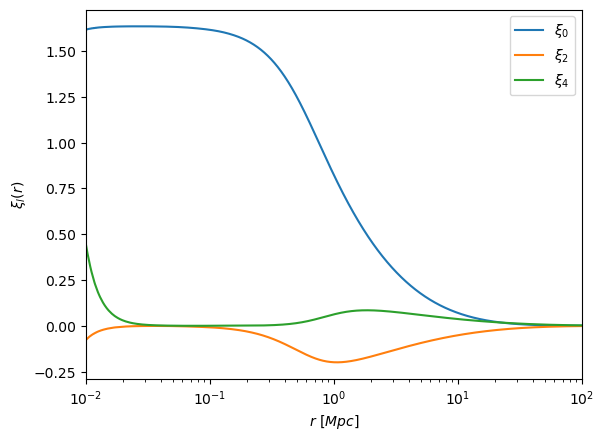

In [8]:
plt.semilogx(r_Mpc, xi_L_0(r_Mpc), label=r'$\xi_{0}$')
plt.semilogx(r_Mpc, xi_L_2(r_Mpc), label=r'$\xi_{2}$')
plt.semilogx(r_Mpc, xi_L_4(r_Mpc), label=r'$\xi_{4}$')
plt.xlim(1e-2,1e2)
plt.xlabel(r'$r ~ [Mpc]$')
plt.ylabel(r'$\xi_l(r)$')
plt.legend();

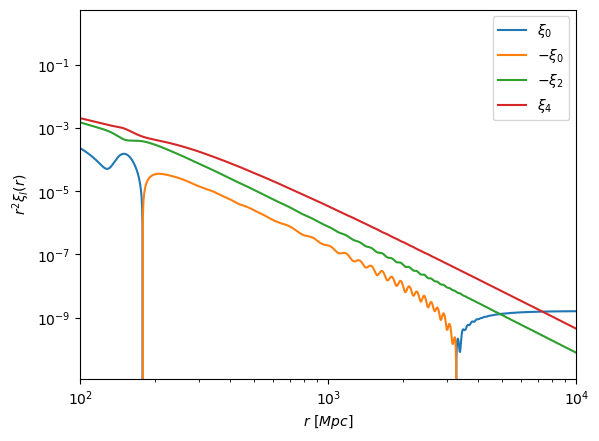

In [9]:
plt.loglog(r_Mpc, r_Mpc**0*xi_L_0(r_Mpc), label=r'$\xi_{0}$')
plt.loglog(r_Mpc, -r_Mpc**0*xi_L_0(r_Mpc), label=r'$-\xi_{0}$')
plt.loglog(r_Mpc, -r_Mpc**0*xi_L_2(r_Mpc), label=r'$-\xi_{2}$')
plt.loglog(r_Mpc, r_Mpc**0*xi_L_4(r_Mpc), label=r'$\xi_{4}$')
plt.xlim(1e2,1e4)
plt.xlabel(r'$r ~ [Mpc]$')
plt.ylabel(r'$r^{2} \xi_l(r)$')
plt.legend();

### Modeling the linear bias parameters

In [10]:
# evolution of the Lya bias parameter as a function of redshift
def b_F_z(z):
    # losely inspired by DESI Lya 
    return -0.12*((1+z)/(1+2.3))**2.9

In [11]:
# evolution of the Lya beta parameter as a function of redshift
def beta_F_z(z):
    # losely inspired by DESI Lya
    return 1.6

In [12]:
# evolution of the linear galaxy bias as a function of redshift
def b_g_z(z):
    # inspired by fitting function on Slack (by Ellen)
    return 0.773*z + 0.387

In [13]:
# evolution of the galaxy RSD parameter (derived)
def beta_g_z(z):
    return f_z(z)/b_g_z(z)

In [14]:
# useful function to assign biases to an input tracer type
def get_bias_beta(z, tracer):
    if tracer == 'F':
        b=b_F_z(z)
        beta=beta_F_z(z)
    elif tracer == 'g':
        b=b_g_z(z)
        beta=beta_g_z(z)
    else:
        raise ValueError('unknown tracer', tracer)
    return b, beta

### Obtain Legendre polynomials of order 0, 2, 4 to weight the multipoles

In [15]:
# there might be a cleaner way, but this works well
L_0=np.polynomial.legendre.Legendre(1)
L_2=np.polynomial.legendre.Legendre((0,0,1))
L_4=np.polynomial.legendre.Legendre((0,0,0,0,1))

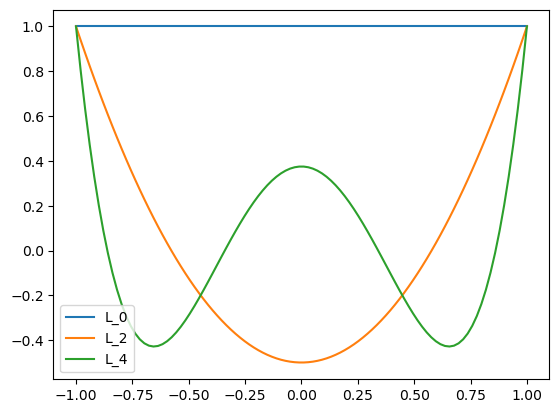

In [16]:
mu=np.linspace(-1,1,100)
plt.plot(mu,L_0(mu),label='L_0')
plt.plot(mu,L_2(mu),label='L_2')
plt.plot(mu,L_4(mu),label='L_4')
plt.legend();

### Compute the anisotropic correlations for two tracers

To do this properly, one should model the asymmetric correlation xi3d(z_1, z_2, r_perp) but let us assume it is symmetric for now... 

In [17]:
def xi3d_zrmu(z, r_Mpc, mu, tracer_1='g', tracer_2=None):
    # get bias / beta for each tracer, at input z
    b_1, beta_1 = get_bias_beta(z, tracer_1)
    # when running auto-correlations, no need for a second tracer
    if tracer_2 is None:
        b_2, beta_2 = b_1, beta_1
    else:
        b_2, beta_2 = get_bias_beta(z, tracer_2)
    # figure out the RSD weights for each multipole (eq 4.6 - 4.8 in Slosar et al 2011)
    C_0 = 1 + (beta_1+beta_2)/3 + beta_1*beta_2/5
    C_2 = 2*(beta_1+beta_2)/3 + 4*beta_1*beta_2/7
    C_4 = 8*beta_1*beta_2/35
    # sum up contribution from each multipole
    xi = C_0 * L_0(mu) * xi_L_0(r_Mpc) \
        + C_2 * L_2(mu) * xi_L_2(r_Mpc) \
        + C_4 * L_4(mu) * xi_L_4(r_Mpc)
    # correct for redshift evolution of matter clustering, and multiply by biases
    return xi * b_1 * b_2 * D_z_p(z,z_p)**2

Text(0.5, 1.0, 'galaxy auto-correlation at z=2.5')

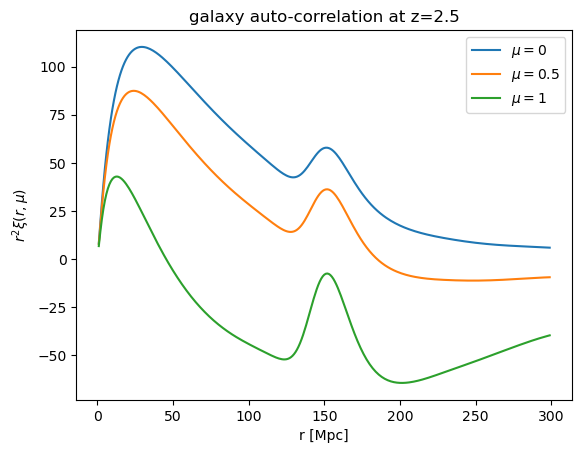

In [18]:
# plot galaxy auto-correlation for a couple of mu values
r = np.arange(1,300,1)
tracer_1='g'
z = 2.5
for mu in [0, 0.5, 1]:
    plt.plot(r, r**2*xi3d_zrmu(z, r, mu, tracer_1), label=r'$\mu={}$'.format(mu))
plt.xlabel('r [Mpc]')
plt.ylabel(r'$r^2 \xi(r, \mu)$')
plt.legend()
plt.title('galaxy auto-correlation at z={}'.format(z))

Text(0.5, 1.0, 'Lya auto-correlation at z=2.5')

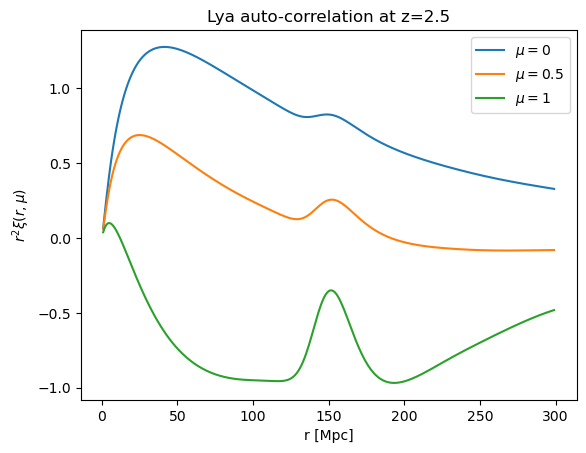

In [19]:
# plot Lya auto-correlation for a couple of mu values
r = np.arange(1,300,1)
tracer_1='F'
z = 2.5
for mu in [0, 0.5, 1]:
    plt.plot(r, r**2*xi3d_zrmu(z, r, mu, tracer_1), label=r'$\mu={}$'.format(mu))
plt.xlabel('r [Mpc]')
plt.ylabel(r'$r^2 \xi(r, \mu)$')
plt.legend()
plt.title('Lya auto-correlation at z={}'.format(z))

Text(0.5, 1.0, 'Lya-galaxy cross-correlation at z=2.5')

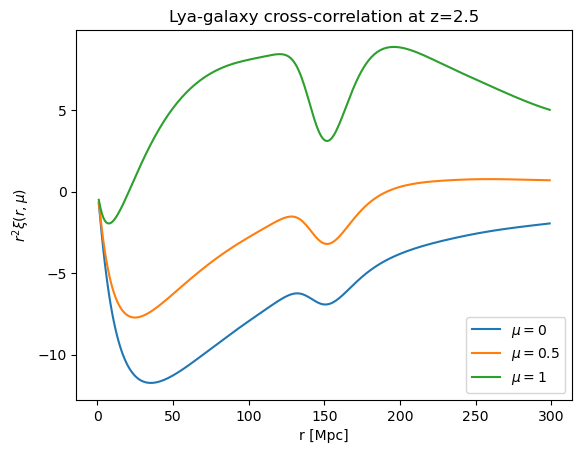

In [20]:
# plot galaxy-Lya cross-correlation for a couple of mu values
r = np.arange(1,300,1)
tracer_1='F'
tracer_2='g'
z = 2.5
for mu in [0, 0.5, 1]:
    plt.plot(r, r**2*xi3d_zrmu(z, r, mu, tracer_1, tracer_2), label=r'$\mu={}$'.format(mu))
plt.xlabel('r [Mpc]')
plt.ylabel(r'$r^2 \xi(r, \mu)$')
plt.legend()
plt.title('Lya-galaxy cross-correlation at z={}'.format(z))